# Проект: классификация

In [1008]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [909]:
# Скачать файл с данными по ссылке
# https://drive.google.com/file/d/1BR7EJ4t31ckj8cmjM_Hqqz9Hs76UwwUy/view

df = pd.read_csv('bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [910]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()
print(f"Количество записей с пропущенным баллансом: {df[df['balance'].isnull()].shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
Количество записей с пропущенным баллансом: 25


### Задание 2

In [911]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
print(f"значения признака job: {df['job'].unique()}")

# значение 'unknown' в признаке job заменяет пропущенное значение
print(f"пропущенных значений признака job: {df[df['job'] == 'unknown']['job'].count()}")

значения признака job: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
пропущенных значений признака job: 70


### Задание 3

In [912]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
if df['balance'].dtype == 'object':
    df['balance'] = df['balance'].str.replace(',00', '').str.replace('$', '').str.replace(' ', '')
    df['balance'] = df['balance'].astype('float')
print(f"Тип признака balance: {df['balance'].dtype}")

Тип признака balance: float64


### Задание 4

In [913]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

print(f"Среднее balance: {df['balance'].mean()}")


Среднее balance: 1526.9360329690019


### Задание 5

In [914]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
for column in ['job', 'education']:
    mode_value = df[column].mode()[0]
    df[column] = df[column].apply(lambda x: mode_value if x == 'unknown' else x)

In [915]:
# Задание 2.5
# После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой
# и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа
# и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

# находим популярную работу и популярный уровень образования
job_popular = df['job'].mode()[0]
education_popular = df['education'].mode()[0]
print(f"популярная работа: {job_popular}")
print(f"Популярный уровень образования: {education_popular}")

mask = (df['job'] == job_popular) & (df['education'] == education_popular)
print("Средний балланс: %.3f" % df[mask]['balance'].mean())

популярная работа: management
Популярный уровень образования: secondary
Средний балланс: 1598.883


### Задание 6

In [916]:
# Задание 2.6
# Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.
q1 = np.quantile(df['balance'], 0.25)
q3 = np.quantile(df['balance'], 0.75)
iqr = q3 - q1
lower_range = q1 - 1.5 * iqr
upper_range = q3 + 1.5 * iqr

print(f"Граница: ({lower_range}, {upper_range})")

filter_mask = (df['balance'] >= lower_range) & (df['balance'] <= upper_range)

# удалите все выбросы для признака balance
df_filtered = df.loc[filter_mask]
df_filtered.shape

Граница: (-2241.0, 4063.0)


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: age, dtype: int64
deposit
no     0.536764
yes    0.463236
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Количество клиентов, которые открыли депозит')

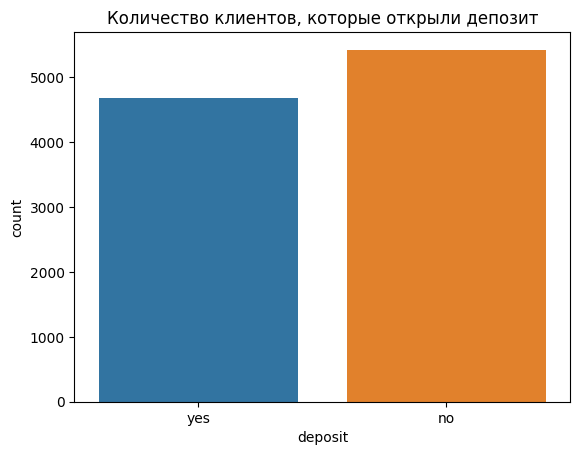

In [917]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df = df_filtered

print(df.groupby('deposit').count()['age'])
print(df['deposit'].value_counts(normalize=True))
sns.countplot(data=df, x='deposit').set_title("Количество клиентов, которые открыли депозит")


#### Вывод
Количество клиентов из разных классов (yes - которые открыли депозит, no - которые не открыли депозит) отличаются меньше чем на 10%, поэтому можно считать, что классы сбалансированы.

### Задания 2 и 3

Описательные статистики для всех клиетов


,age,balance,day,duration,campaign,pdays,previous
count,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000
mean,41.203162,953.071566,15.073489,539.568896,2.136296,68.776757,1.157018
std,13.291117,1040.543075,8.503427,394.408498,1.921040,119.854999,2.542359
min,18.000000,-1944.000000,1.000000,8.000000,1.000000,-1.000000,0.000000
25%,31.000000,163.000000,8.000000,245.000000,1.000000,-1.000000,0.000000
50%,38.000000,569.000000,15.000000,429.000000,2.000000,-1.000000,0.000000
75%,49.000000,1495.000000,21.000000,727.000000,2.000000,98.000000,1.000000
max,95.000000,4060.000000,31.000000,3881.000000,32.000000,854.000000,58.000000


Описательные статистики для клиетов открывших депозит в банке


,age,balance,day,duration,campaign,pdays,previous
count,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000
mean,41.203162,953.071566,15.073489,539.568896,2.136296,68.776757,1.157018
std,13.291117,1040.543075,8.503427,394.408498,1.921040,119.854999,2.542359
min,18.000000,-1944.000000,1.000000,8.000000,1.000000,-1.000000,0.000000
25%,31.000000,163.000000,8.000000,245.000000,1.000000,-1.000000,0.000000
50%,38.000000,569.000000,15.000000,429.000000,2.000000,-1.000000,0.000000
75%,49.000000,1495.000000,21.000000,727.000000,2.000000,98.000000,1.000000
max,95.000000,4060.000000,31.000000,3881.000000,32.000000,854.000000,58.000000


Описательные статистики для клиетов не открывших депозит в банке


,age,balance,day,duration,campaign,pdays,previous
count,5424.000000,5424.00000,5424.000000,5424.000000,5424.000000,5424.000000,5424.000000
mean,40.629978,682.15542,16.036320,221.316740,2.845870,36.253872,0.522124
std,10.196686,934.37434,8.362851,206.688801,3.199471,97.527835,1.901471
min,18.000000,-2049.00000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,33.000000,46.00000,8.000000,93.000000,1.000000,-1.000000,0.000000
50%,39.000000,342.00000,16.000000,163.000000,2.000000,-1.000000,0.000000
75%,48.000000,992.00000,22.000000,278.000000,3.000000,-1.000000,0.000000
max,89.000000,4063.00000,31.000000,3284.000000,43.000000,826.000000,41.000000


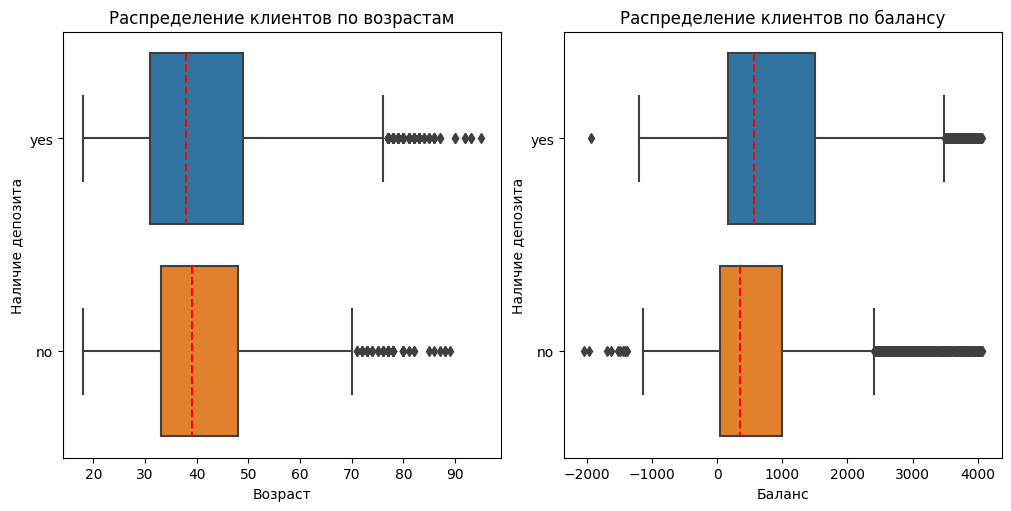

In [918]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print('Описательные статистики для всех клиетов')
display(df[df['deposit'] == 'yes'].describe())
print('Описательные статистики для клиетов открывших депозит в банке')
display(df[df['deposit'] == 'yes'].describe())
print('Описательные статистики для клиетов не открывших депозит в банке')
display(df[df['deposit'] == 'no'].describe())

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

sns.boxplot(
    data=df,
    x='age',
    y='deposit',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    ax=axes[0],
).set(
    title='Распределение клиентов по возрастам',
    xlabel='Возраст',
    ylabel='Наличие депозита',
)

ax = sns.boxplot(
    data=df,
    x='balance',
    y='deposit',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    ax=axes[1],
).set(
    title='Распределение клиентов по балансу',
    xlabel='Баланс',
    ylabel='Наличие депозита',
)

plt.show()


#### Выводы
* возраст клиентов от 18 до 95 лет (старше 75 показаны как выбросы в обеих группах, возможно, это связано с меньшим колличеством людей такого возраста)
* баланс от -2000 до 4000 (выбросы есть как меньше -1000, так и и больше 3000-3500 в обеих группах)

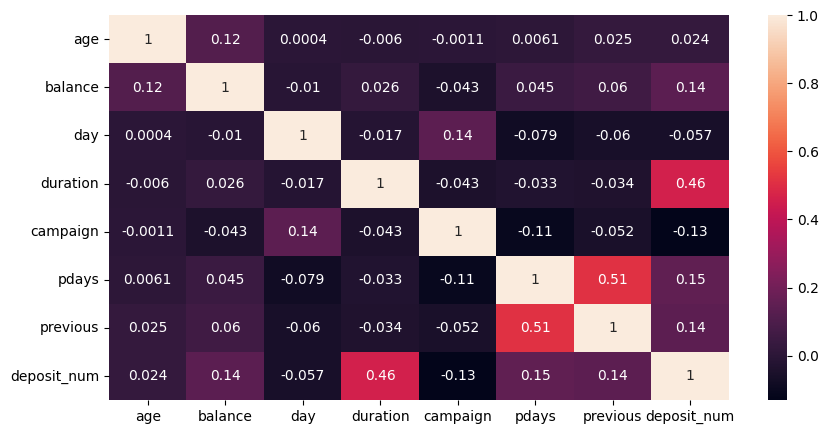

In [919]:
df_copy = df.copy()
df_copy['deposit_num'] = df_copy['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

plt.figure(figsize = (10, 5))
sns.heatmap(df_copy[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'deposit_num']].corr(), annot = True)
plt.show()

#### Вывод
Из колличественных признаков только признак `duration` показывает среднию корреляцию с целевым признаком `deposit`. Остальные признаки показывают очень слабую корреляцию.

Переведем `duration` в минуты и посмотрим на распределение клиетов от времени общения

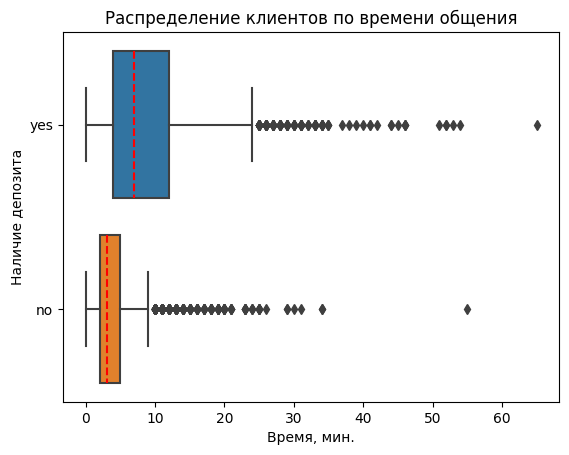

In [920]:

df_copy['duration_min'] = df_copy['duration'].apply(lambda x: round(x/60))

ax = sns.boxplot(data=df_copy, x='duration_min', y='deposit', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Время, мин.', ylabel='Наличие депозита')
plt.title('Распределение клиентов по времени общения')
plt.show()

#### Выводы
* визаульно наблюдается отличие времени общения для клиентов из двух групп: 
    - данные для клиентов с депозитом разбросаны больше
    - наблюдается увеличение времени общения для клиентов с депозитом
* проведем дополнительные тесты, чтобы проверить различно ли время общения для клиентов из разных групп

Проведем дополнительный тест на нормальность признака `duration` - тест Шапиро-Уилка:

In [921]:
from scipy.stats import shapiro

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

# уровень значимости
alpha = 0.05

_, p = shapiro(df[df['deposit'] == 'yes']['duration'])
print('p=%.3f' % p)

# Интерпретация
print(H0 if p > alpha else Ha)


p=0.000
Данные не распределены нормально (мы отвергаем H0)


**Выберем подходящий статистический тест для проверки отличается ли время общения между клиентами в разных группах**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака `duration`? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать критерий U-критерий Манна-Уитни.

**Проведём тест**

In [922]:
from scipy import stats

def decision_hypothesis(p):
    print('p-value = {:.4f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

with_deposit = df[df['deposit'] == 'yes']['duration']
no_deposit = df[df['deposit'] == 'no']['duration']

H0 = 'Нулевая гипотеза: медиана времени общения с клиентами с депозитом (m1) не отличается\
    от медианы времени общения с клиентами без депозита (m2).'
H1 = 'Альтернативная гипотеза: медиана времени общения с клиентами с депозитом (m1) отличается\
    от медианы времени общения с клиентами без депозита (m2).'

_, p = stats.mannwhitneyu(with_deposit, no_deposit, alternative='two-sided')
decision_hypothesis(p)

p-value = 0.0000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


#### Вывод
Среднее значение времени общения с клиентами с депозитом статистически отличается от времени общения с клиентами без депозита

### Задания 4 и 5

In [923]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [924]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

print("=== Частоты категориальных признаков ===")
display(df['job'].value_counts())
display(df['marital'].value_counts())
display(df['education'].value_counts())
display(df['default'].value_counts())
display(df['housing'].value_counts())
display(df['loan'].value_counts())
display(df['contact'].value_counts())
display(df['month'].value_counts())
display(df['poutcome'].value_counts())


=== Частоты категориальных признаков ===


job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

marital
married     5715
single      3213
divorced    1177
Name: count, dtype: int64

education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64

default
no     9939
yes     166
Name: count, dtype: int64

housing
no     5243
yes    4862
Name: count, dtype: int64

loan
no     8712
yes    1393
Name: count, dtype: int64

contact
cellular     7283
unknown      2161
telephone     661
Name: count, dtype: int64

month
may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: count, dtype: int64

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

Text(0.5, 1.0, 'Сферы занятости клиентов банка')

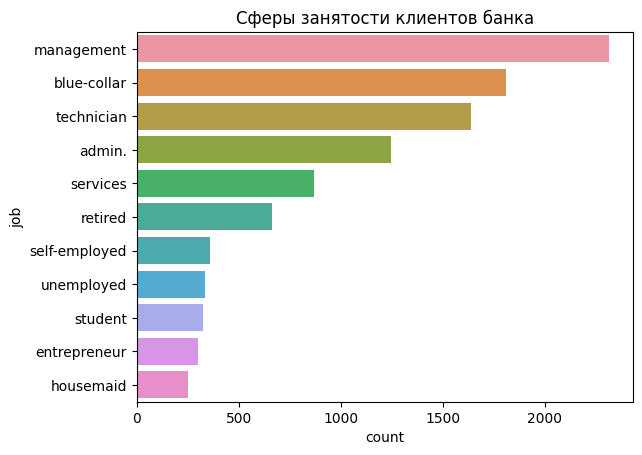

In [925]:
data = df['job'].value_counts()
sns.barplot(y=data.index, x=data, orient='h').set_title("Сферы занятости клиентов банка")

### Задание 6

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64


<Axes: xlabel='poutcome'>

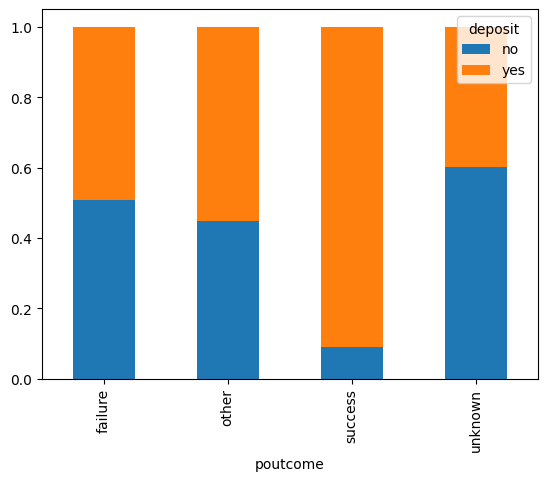

In [926]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
print(df.groupby('poutcome')['deposit'].value_counts())

types = df.groupby('poutcome')['deposit'].value_counts(normalize=True).unstack()
types.plot(kind='bar', stacked='True')

#### Вывод
Мы видим, что только два статуса предыдущей компании показывают большее количество успеха в текущей компании (когда клиенты соглашаются на депозит):
* `success` - 841 (yes) и 84 (no)
* `other` - 265 (yes) и 216 (no)

Можно сделать вывод, что люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь

### Задание 7

In [927]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
failures = {}
for next_month in df['month'].unique():
    data = pd.DataFrame(df[df['month'] == next_month]['deposit'], columns=['deposit'])
    total_count = data.shape[0]
    failures_count = data[data['deposit'] == 'no'].shape[0]
    failures[next_month] = round(failures_count / total_count * 100, 3)

sorted_months = sorted(failures.items(), key=lambda x:x[1], reverse=True)
failures = dict(sorted_months)

display(failures)

{'may': 67.864,
 'jan': 60.815,
 'jul': 58.956,
 'nov': 58.462,
 'aug': 55.957,
 'jun': 54.891,
 'feb': 45.557,
 'apr': 38.193,
 'oct': 18.507,
 'sep': 16.547,
 'mar': 10.127,
 'dec': 9.677}

Больше всего отказывались от предложения открыть депозит в мае.
Посмотрим динамику отказов по дням:

Text(0.5, 1.0, 'Отказы в мае по дням')

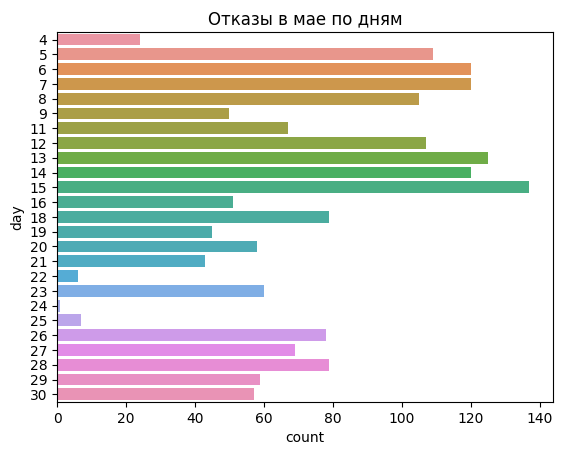

In [928]:
mask = (df['deposit'] == 'no') & (df['month'] == 'may')
data = df[mask]['day'].value_counts()
sns.barplot(y=data.index, x=data, orient='h').set_title("Отказы в мае по дням")

#### Промежуточные выводы
* видны ярко выраженные группы дней с 5 по 8 мая, и с 12 по 15 мая с наибольшим количеством отказов
* трудно сказать, если ли связь междо отказом и днем месяца
* предположу, что в мае просто было больше обращений к клиентам по сравнению с другими месяцами

Text(0.5, 1.0, 'Общее количество обращений по месяцам')

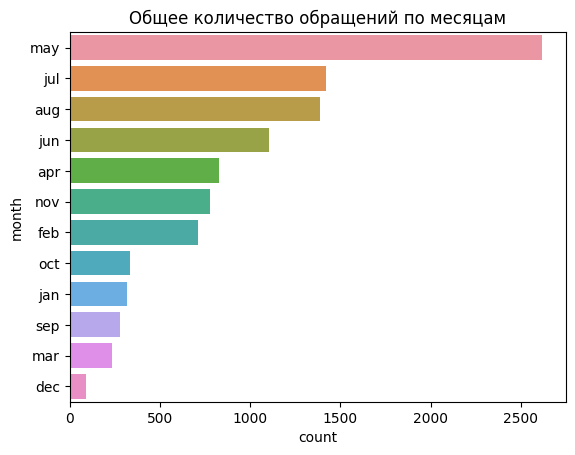

In [929]:
data = df['month'].value_counts()
sns.barplot(y=data.index, x=data, orient='h').set_title("Общее количество обращений по месяцам")

#### Проверим, есть ли вообще связь между двумя категориальными признаками `month` и `deposit`

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между двумя категориальными признаками `month` и `deposit` нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между двумя категориальными признаками `month` и `deposit` есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер компании»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [930]:
cross_tab = pd.crosstab(index=df['month'], columns=df['deposit'])
display(cross_tab)

# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_tab)
decision_hypothesis(p)

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


p-value = 0.0000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


### Выводы
* у нас есть основание утверждать, что категориальные признаки `month` и `deposit` взаимосвязаны
* в процентном отношении больше всего отказом было в мае, что не удивительно, поскольку в мае было больше всего обращений
* интересен месяц январь:
  - в процентном отношении по отказам он на 2-м месте
  - в общем количестве обращений - на 9-м месте.
* можно предположить, что январь - наиболее неблагополучный месяц по отказам

### Задание 8

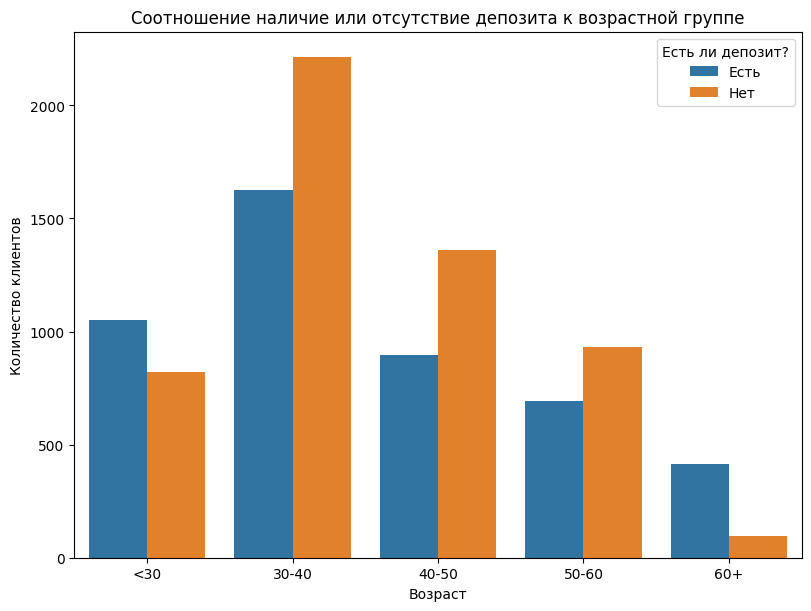

In [931]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

# def get_age_group(age):
#     if age < 30:
#         return '<30'
#     if age < 40:
#         return '30-40'
#     if age < 50:
#         return '40-50'
#     if age < 60:
#         return '50-60'
#     return '60+'
# df['age_group'] = df['age'].apply(get_age_group)

df['age_group'] = pd.cut(df['age'], [0, 30, 40, 50, 60, 9999], labels=['<30', '30-40', '40-50', '50-60', '60+'])

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

sns.countplot(data=df, x='age_group', hue='deposit', ax=ax, order=['<30', '30-40', '40-50', '50-60', '60+'])
ax.set(xlabel='Возраст', ylabel='Количество клиентов')

plt.title('Соотношение наличие или отсутствие депозита к возрастной группе')
plt.legend(labels=['Есть', 'Нет'], title="Есть ли депозит?")
plt.show()

#### Вывод
Клиеты младше 30 и 60+ склонны более склонны открывать депозит

### Задания 9 и 10

(array([0, 1, 2]),
 [Text(0, 0, 'divorced'), Text(1, 0, 'married'), Text(2, 0, 'single')])

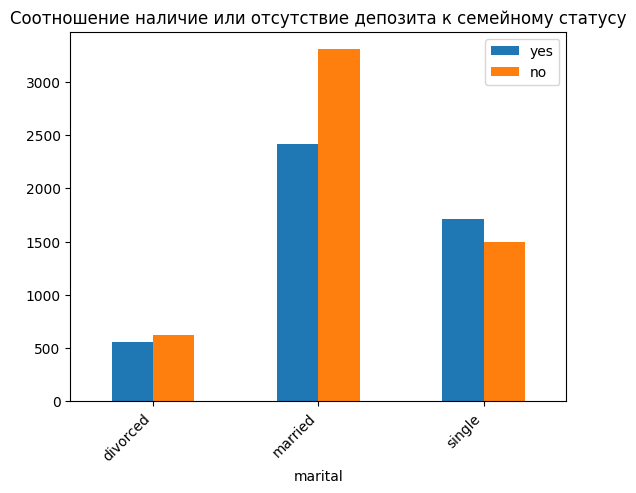

In [932]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
ax = pd.concat(
    [
        df[df['deposit'] == 'yes'].groupby('marital').count()['age'].rename('yes'),
        df[df['deposit'] == 'no'].groupby('marital').count()['age'].rename('no')
    ],
    axis=1
).plot.bar()
ax.set_title('Соотношение наличие или отсутствие депозита к семейному статусу')
plt.xticks(rotation=45, ha='right')


<Axes: xlabel='count', ylabel='marital'>

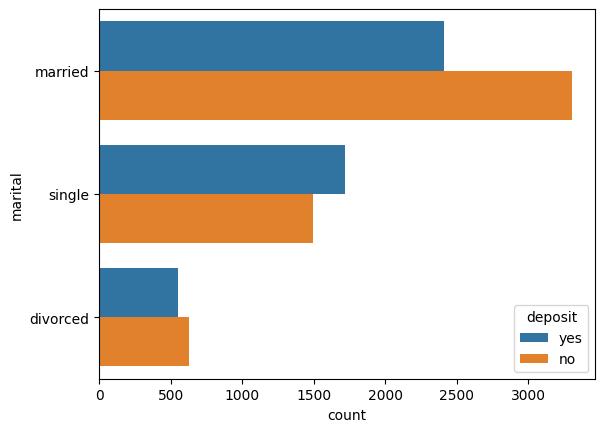

In [933]:
sns.countplot(data=df, y='marital', hue='deposit')

#### Выводы
* большая часть людей женатые/замужние люди
* они же имеют тенденцию отказываться открыть депозит
* при семейном положении `single` есть тенденция открывать депозит, а не отказываться от его открытия.

(array([0, 1, 2]),
 [Text(0, 0, 'primary'), Text(1, 0, 'secondary'), Text(2, 0, 'tertiary')])

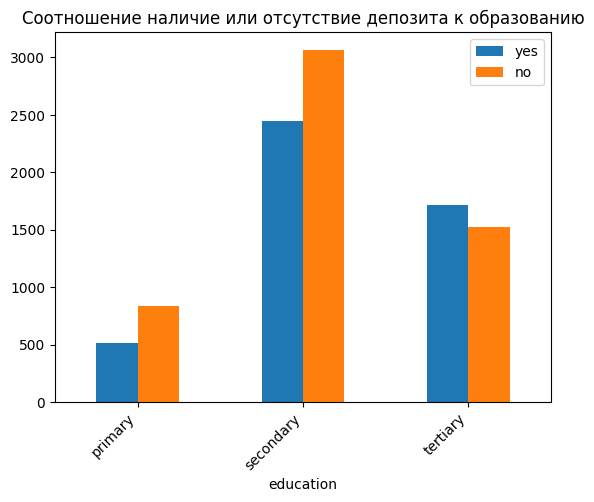

In [934]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ax = pd.concat(
    [
        df[df['deposit'] == 'yes'].groupby('education').count()['age'].rename('yes'),
        df[df['deposit'] == 'no'].groupby('education').count()['age'].rename('no')
    ],
    axis=1
).plot.bar()
ax.set_title('Соотношение наличие или отсутствие депозита к образованию')
plt.xticks(rotation=45, ha='right')


#### Выводы
* у большая части клиентов среднее образование (`secondary`)
* они же (как и клиенты с уровнем образования `primary`) имею тенденцию отказываться от депозита
* При образовании `teriary` есть тенденция открывать депозит, а не отказываться от его открытия.

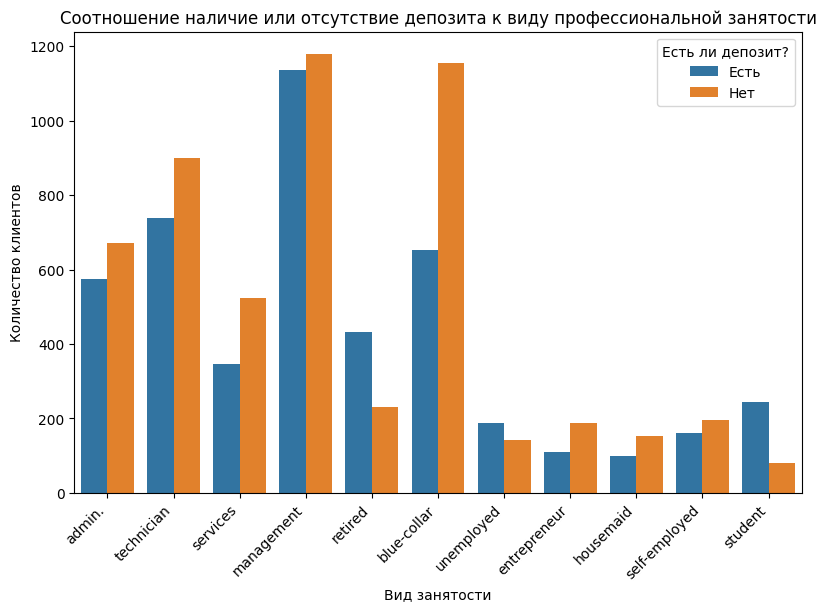

In [935]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)

sns.countplot(data=df, x='job', hue='deposit', ax=ax)
ax.set(xlabel='Вид занятости', ylabel='Количество клиентов')

plt.title('Соотношение наличие или отсутствие депозита к виду профессиональной занятости')
plt.legend(labels=['Есть', 'Нет'], title="Есть ли депозит?")
plt.xticks(rotation=45, ha='right')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'management'),
  Text(1, 0, 'blue-collar'),
  Text(2, 0, 'technician'),
  Text(3, 0, 'admin.'),
  Text(4, 0, 'services'),
  Text(5, 0, 'retired'),
  Text(6, 0, 'self-employed'),
  Text(7, 0, 'unemployed'),
  Text(8, 0, 'student'),
  Text(9, 0, 'entrepreneur'),
  Text(10, 0, 'housemaid')])

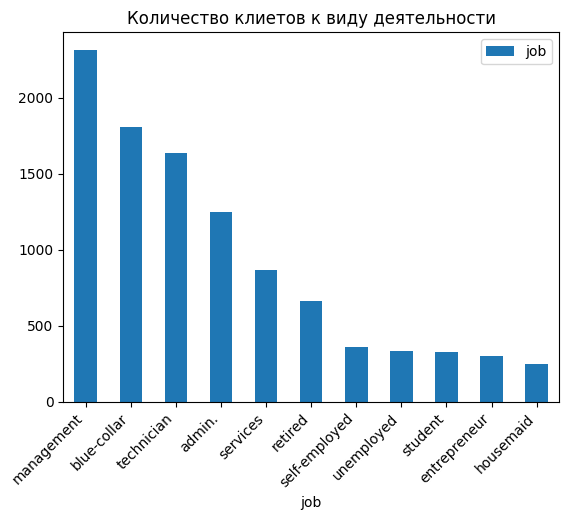

In [936]:
data = df.groupby('job').count()['age'].sort_values(ascending=False)

ax = pd.concat(
    [
        data.rename('job'),
    ],
    axis=1
).plot.bar()
ax.set_title('Количество клиетов к виду деятельности')
plt.xticks(rotation=45, ha='right')


#### Выводы
* больше всего клиентов работае в сфере менеджемта
* больше всего отказываются от депозита рабочие (`blue-collar`)
* студенты (`student`), пенсионеры (`retired`) и безработные (`unemployed`) имеют тенденцию открывать депозит, а не отказываться от его открытия.

### Задание 11

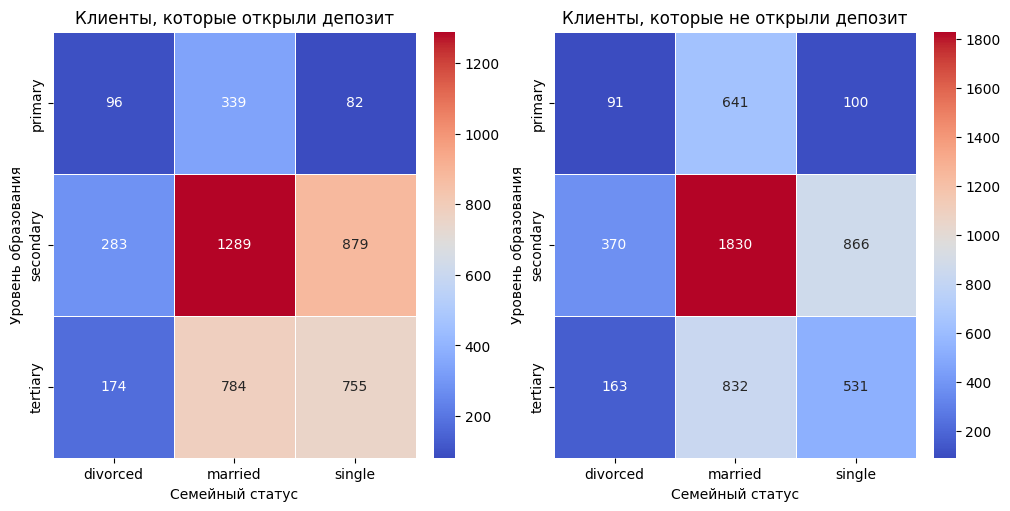

In [937]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

data = df[df['deposit'] == 'yes']
pivot = data.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)
pivot.columns = pivot.columns.astype('string')

data_no_deposit = df[df['deposit'] == 'no']
pivot_no_deposit = data_no_deposit.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)
pivot_no_deposit.columns = pivot_no_deposit.columns.astype('string')

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

sns.heatmap(
    pivot,
    annot=True,
    linewidth=.5,
    fmt='.0f',
    cmap="coolwarm",
    ax=axes[0],
).set(
    xlabel='Семейный статус',
    ylabel='Уровень образования',
    title='Клиенты, которые открыли депозит',
)

sns.heatmap(
    pivot_no_deposit,
    annot=True,
    linewidth=.5,
    fmt='.0f',
    cmap="coolwarm",
    ax=axes[1],
).set(
    xlabel='Семейный статус',
    ylabel='Уровень образования',
    title='Клиенты, которые не открыли депозит',
)

plt.show()

#### Выводы
* наиболее многочисленны женатые/замужние клиенты (`married`) со средним образованием (`secondary`) в обеих группах (открывшие депозит или нет)
* наименее многочисленне разведенные или одинокие клиенты с начальным образованием (`primary`) в обеих группах (хотя результаты противоположны в группах, но разница не значительна)

## Часть 3: преобразование данных

### Задание 1

In [938]:
# преобразуйте уровни образования
le = LabelEncoder()
le.fit(df['education'])
if df.dtypes['education'] == 'object':
    df['education'] = le.transform(df['education'])

print(df['education'].sum())


11995


### Задания 2 и 3

In [939]:
# преобразуйте бинарные переменные в представление из нулей и единиц
if df.dtypes['deposit'] == 'object':
    le = LabelEncoder()
    le.fit(df['deposit'])
    df['deposit'] = le.transform(df['deposit'])
df['deposit'].describe()

count    10105.000000
mean         0.463236
std          0.498671
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: deposit, dtype: float64

In [940]:
# Задание 4.3
# Вычислите среднее арифметическое для каждой из получившихся переменных,
# сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.

total_mean = 0
for column in ['default', 'housing', 'loan']:
    if df.dtypes[column] == 'object':
        df[column] = df[column].apply(lambda x: 1 if x == 'yes' else 0)
    total_mean += df[column].mean()

print(f"Сумма средних арифметических: {total_mean:.3f}")

Сумма средних арифметических: 0.635


### Задание 4

In [941]:
# создайте дамми-переменные
cols_to_dummies = ['job', 'marital', 'contact', 'month', 'poutcome']
df_with_dummies = pd.get_dummies(df, columns=cols_to_dummies, drop_first=False)
df_with_dummies_and_original = pd.concat([df[cols_to_dummies], df_with_dummies], axis=1)

# Задание 4.4
# Сколько теперь всего признаков в датасете, не считая целевую переменную?
# Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.
print(f"Всего признаков (кроме целевого) после добавления дамми-переменных: {df_with_dummies_and_original.shape[1] - 1}")

Всего признаков (кроме целевого) после добавления дамми-переменных: 50


### Задания 5 и 6

<Axes: >

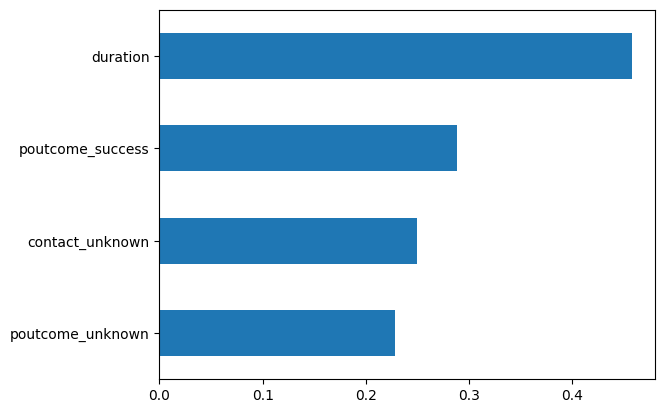

In [942]:
df = df_with_dummies.copy()

# преобразуем признак age_group для вычисления корреляции и моделирования
if df.dtypes['age_group'] == 'category':
    le = LabelEncoder()
    le.fit(df['age_group'])
    df['age_group'] = le.transform(df['age_group'])
    df_with_dummies['age_group'] = le.transform(df_with_dummies['age_group'])

corr_table = df.corr()
corr_table['deposit'].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()

# sns.heatmap(
#     df.corr(),
#     annot=True,
#     linewidth=5,
#     fmt='.1f',
#     cmap="coolwarm",
# )

In [944]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

data = df.corr()
display(data)

# Задание 4.6
# Есть ли среди признаков мультиколлинеарность? Будем считать достаточно сильной корреляцию не менее 0.9.

is_found_multi_corr = False
for col in data.columns:
    mask = ((df[col] >= 0.9) & (df[col] < 1)) | ((df[col] > -1) & (df[col] <= -0.9))
    next = df.loc[mask]
    if next.shape[0] > 0:
        print(f"==== column ({col}) ===")
        print(next.shape)
        is_found_multi_corr = True

if is_found_multi_corr:
    print("Найдена мультиколлинеарность!")
else:
    print("Мультиколлинеарность среди признаков не найдена.")


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,...,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,...,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,...,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,...,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,...,-0.003061,-0.034640,0.007983,-0.015655,-0.012541,-0.012077,-0.039476,-0.009497,-0.025971,0.050571
campaign,-0.001143,-0.012280,0.033404,-0.042689,0.006257,0.033889,0.142169,-0.042576,1.000000,-0.105214,...,0.046763,-0.030574,-0.044348,-0.077307,-0.071519,-0.048672,-0.082282,-0.024854,-0.094260,0.134842
pdays,0.006107,0.024123,-0.037323,0.045155,0.064138,-0.030788,-0.078757,-0.033053,-0.105214,1.000000,...,-0.093551,0.024192,0.028678,-0.007350,0.079833,0.110907,0.608719,0.338049,0.326215,-0.824031


Мультиколлинеарность среди признаков не найдена.


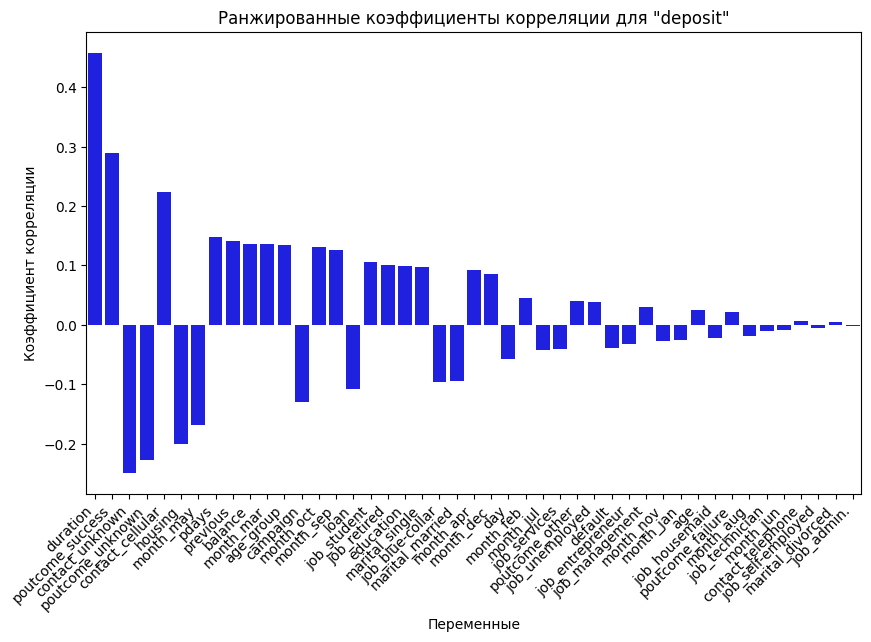

In [945]:
# Данные для построения диаграммы
data_bar = data['deposit'].drop('deposit')
variable_names = list(data_bar.index)
correlation_values = data_bar

# Сортировка по абсолютному значению коэффициентов корреляции
sorted_indices = sorted(range(len(correlation_values)), key=lambda k: abs(correlation_values[k]), reverse=True)
sorted_variable_names = [variable_names[i] for i in sorted_indices]
sorted_correlation_values = [correlation_values[i] for i in sorted_indices]

# # Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_variable_names, y=sorted_correlation_values, color='blue')
plt.xlabel('Переменные')
plt.ylabel('Коэффициент корреляции')
plt.title('Ранжированные коэффициенты корреляции для "deposit"')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Выводы:
* Топ признаков, коррелирующие с основным признаком в порядке убывания:
  - `duration`
  - `poutcome_success`
  - `contact_unknown`
* мультиколлинеарности среди признаков не наблюдается

### Задания 7 и 8

In [946]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [947]:
# рассчитайте необходимые показатели
print(f"размер тестовой выборки: {X_test.shape}")
print(f"среднее значение целевой переменной на тестовой выборке: {round(y_test.mean(), 2)}")

размер тестовой выборки: (3335, 45)
среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [948]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

columns_kbest = list(selector.get_feature_names_out())
print(f"Выбранные столбцы: {columns_kbest}")


Выбранные столбцы: ['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous', 'age_group', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


### Задание 10

In [950]:
# нормализуйте данные с помощью minmaxsxaler

X = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
         'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
         'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']]
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

# обучаем MinMaxScaler скейлер на тренировочной выборке
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

# трансформация тренировочных и тестовых данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Задание 4.10
# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки.
# Ответ округлите до двух знаков после точки-разделителя.
print(f"среднее арифметическое для первого предиктора: {X_test_scaled[:, 0].mean():.2f}")

среднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [951]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000,
)
log_reg.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test_scaled, y_test)))



accuracy на тестовом наборе: 0.81


### Задания 2,3,4

In [954]:
# обучите решающие деревья, настройте максимальную глубину

dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42 #генератор случайных чисел
)
dt.fit(X_train_scaled, y_train)

#Делаем предсказание класса на тренировочной выборке
y_train_pred = dt.predict(X_train_scaled)
print('accuracy на тренировочной выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

#Делаем предсказание класса на тестовой выборке
y_test_pred = dt.predict(X_test_scaled)
print('accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


accuracy на тренировочной выборке: 1.00
accuracy на тестовой выборке: 0.75


> Переберите различные максимальные глубины деревьев и найдите глубину дерева, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения (т. е. не будет расти качество на обучающей выборке при неизменном качестве на тестовой).

depth: 1, delta: 0.005074641408985281, accuracy: 0.7064467766116942
depth: 2, delta: 0.010962465591428772, accuracy: 0.7178410794602699
depth: 3, delta: 0.005460637480373509, accuracy: 0.7703148425787106
depth: 4, delta: 0.006208048117743226, accuracy: 0.7697151424287856
depth: 5, delta: 0.010137324247772694, accuracy: 0.7937031484257872
depth: 6, delta: 0.011423977819066788, accuracy: 0.8065967016491754
depth: 7, delta: 0.02163969713813696, accuracy: 0.8149925037481259
depth: 8, delta: 0.028022251798768272, accuracy: 0.8128935532233883
depth: 9, delta: 0.0445066979065859, accuracy: 0.8068965517241379


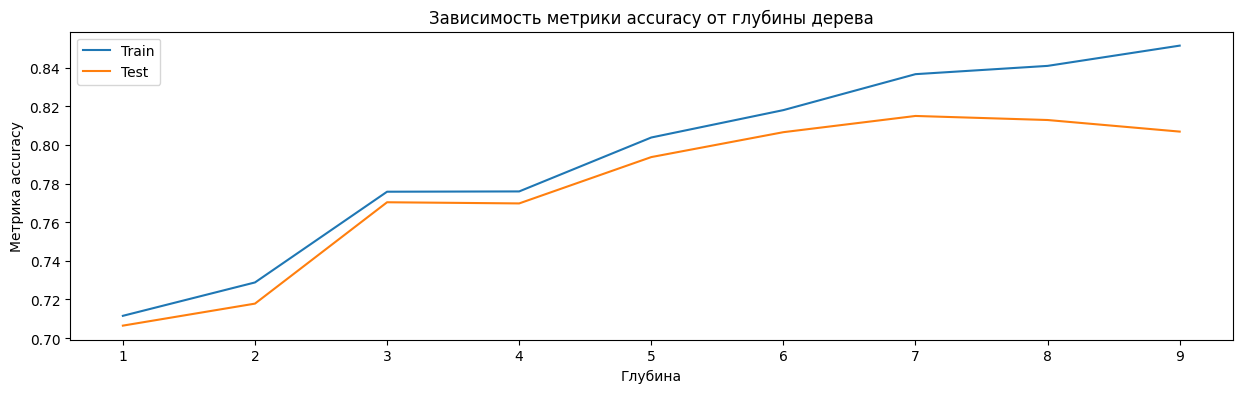

In [961]:
train_metrics = []
test_metrics = []
delta = []
depths = []
for depth in range(1, 10):
    depths.append(depth)

    dt = tree.DecisionTreeClassifier(
        criterion='entropy', #критерий эффективности
        max_depth=depth,
        random_state=42 #генератор случайных чисел
    )
    dt.fit(X_train_scaled, y_train)

    y_train_pred = dt.predict(X_train_scaled)
    next_train_metric = metrics.accuracy_score(y_train, y_train_pred)
    train_metrics.append(next_train_metric)

    y_test_pred = dt.predict(X_test_scaled)
    next_test_metric = metrics.accuracy_score(y_test, y_test_pred)
    test_metrics.append(next_test_metric)

    delta.append(next_train_metric - next_test_metric)

depth = 0
for next_delta in delta:
    print(f"depth: {depth+1}, delta: {next_delta}, accuracy: {test_metrics[depth]}")
    depth += 1

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(depths, train_metrics, label='Train')
ax.plot(depths, test_metrics, label='Test')
ax.set_title('Зависимость метрики accuracy от глубины дерева')
ax.set_xlabel('Глубина')
ax.set_ylabel('Метрика accuracy')
ax.legend()



#### Выводы
* применение алгоритма "решающее дерево" с параметрами по-умолчанию показывает переобучение модели
* наилучшая глубина дерева, при которой не происходит переобычение модели - 6 (при глубине 7 delta уже 0.2, а не 0.1)

### Задание 5

In [973]:
# подберите оптимальные параметры с помощью gridsearch

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7],
}

grid_search_lr = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
    ),
    param_grid=param_grid,
    cv=5,
    scoring=('f1'),
    n_jobs=-1,
    # return_train_score=True,
)

%time grid_search_lr.fit(X_train_scaled, y_train)
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_lr.score(X_test_scaled, y_test)))

y_test_pred = grid_search_lr.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))
# платформа требует значение F1-score равное 0.79

CPU times: user 48.2 ms, sys: 17.1 ms, total: 65.2 ms
Wall time: 153 ms
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 7}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [980]:
# обучите на ваших данных случайный лес

rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42,
)

rf.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test_scaled, y_test)))

y_test_pred = rf.predict(X_test_scaled)
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
# платформа приняла recall score как 0.84

accuracy на тестовом наборе: 0.83
recall на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.82


### Задания 2 и 3

In [981]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42,
)

gb.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(gb.score(X_test_scaled, y_test)))

y_test_pred = gb.predict(X_test_scaled)
print('recall на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('F1-score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
recall на тестовом наборе: 0.83
F1-score на тестовом наборе: 0.82


### Задание 4

In [1023]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    (
        'dt',
        tree.DecisionTreeClassifier(
            criterion='entropy',
            min_samples_leaf=5,
            max_depth=6,
            random_state=42,
        )
    ),
    (
        'log_reg',
        linear_model.LogisticRegression(
            solver='sag',
            random_state=42,
        )
    ),
    (
        'gb',
        ensemble.GradientBoostingClassifier(
            learning_rate=0.05,
            n_estimators=300,
            min_samples_leaf=5,
            max_depth=5,
            random_state=42,
        )
    ),
]

stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        max_iter=1000,
        random_state=42,
    )
)
stack.fit(X_train_scaled, y_train)
y_test_pred = stack.predict(X_test_scaled)

print("precision на тестовом наборе: {:.2f}".format(metrics.precision_score(y_test, y_test_pred)))
print("F1-score на тестовом наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))
# платформа принимает 0.82


precision на тестовом наборе: 0.81
F1-score на тестовом наборе: 0.81


### Задание 5

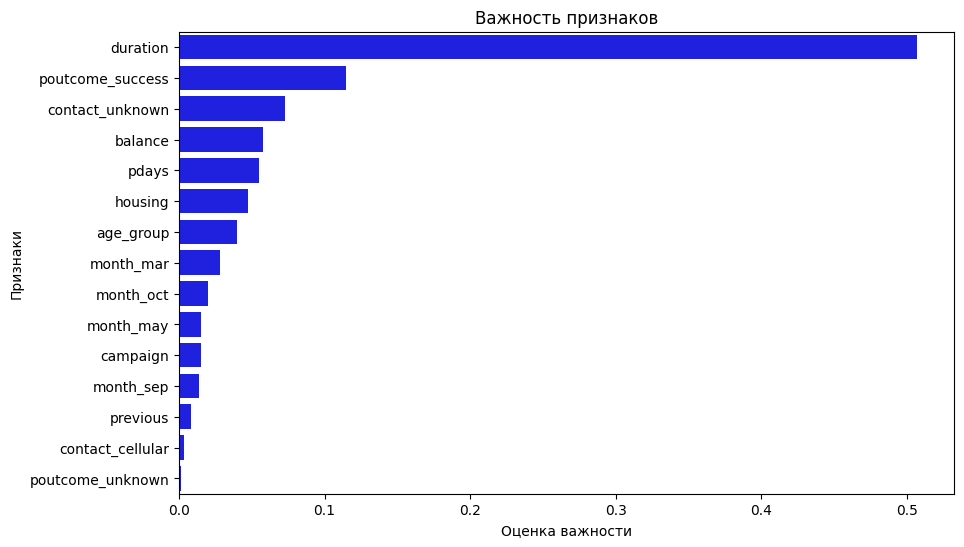

In [1005]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

features = []
scores = []
for next_score, next_feature in sorted(zip(gb.feature_importances_, columns_kbest), reverse=True):
    features.append(next_feature)
    scores.append(next_score)

plt.figure(figsize=(10, 6))
sns.barplot(x=scores, y=features, color='blue')
plt.xlabel('Оценка важности')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()


### Задания 6,7,8

In [1017]:
%%time
# реализуйте оптимизацию гиперпараметров с помощью Optuna

penalty_list = ['l1', 'l2']
solver_list = ['liblinear', 'saga']


def optuna_lr(trial):
    params = {
      'n_estimators': trial.suggest_int('n_estimators', 100, 200, 1),
      'max_depth': trial.suggest_int('max_depth', 10, 30, 1),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10, 1),
    }

    model = RandomForestClassifier(
        **params,
        random_state=42,
    )

    model.fit(X_train_scaled, y_train)

    score = metrics.f1_score(y_train, model.predict(X_train_scaled))

    return score


# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=50)

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2023-11-19 16:39:42,162] A new study created in memory with name: RandomForestClassifier
[I 2023-11-19 16:39:42,537] Trial 0 finished with value: 0.8642399625058584 and parameters: {'n_estimators': 103, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8642399625058584.
[I 2023-11-19 16:39:42,964] Trial 1 finished with value: 0.8786127167630058 and parameters: {'n_estimators': 119, 'max_depth': 22, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8786127167630058.
[I 2023-11-19 16:39:43,448] Trial 2 finished with value: 0.8496075353218211 and parameters: {'n_estimators': 168, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8786127167630058.
[I 2023-11-19 16:39:44,048] Trial 3 finished with value: 0.8705845576742731 and parameters: {'n_estimators': 177, 'max_depth': 15, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8786127167630058.
[I 2023-11-19 16:39:44,644] Trial 4 finished with value: 0.8925671455340412 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 142, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
CPU times: user 25.9 s, sys: 592 ms, total: 26.4 s
Wall time: 26.5 s


In [1018]:
# {'n_estimators': 153, 'max_depth': 25, 'min_samples_leaf': 2}
study.best_params

{'n_estimators': 142, 'max_depth': 28, 'min_samples_leaf': 2}

In [1019]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [1021]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [1020]:
model = RandomForestClassifier(
    **study.best_params,
    random_state=42,
)

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print("f1_score на обучающем наборе: {:.2f}".format(metrics.f1_score(y_test, y_test_pred)))
# 0.83 на платформе

print("accuracy на обучающем наборе: {:.2f}".format(metrics.accuracy_score(y_test, y_test_pred)))
# 0.84 на платформе



f1_score на обучающем наборе: 0.81
accuracy на обучающем наборе: 0.82
